# Communities

In applications, one may want to identify *communities* within a network. There are many ways to define this concept precisely. We will choose a **random-walk** model.

Imagine that a bunny sits on node $i$. In one second, the bunny hops to one of $i$'s neighbors, chosen randomly. In the next second, the bunny hops to another node chosen randomly from the neighbors of the one it is sitting on, etc. This is a random walk on the nodes of the graph.

Now imagine that we place another bunny on node $i$ and track its path as it hops around the graph. Then we place another bunny, etc., so that we have an ensemble of walks. We can now reason about the *probability* of the location of the walk after any number of hops. Initially, the probability of node $i$ is 100%. If $i$ has $m$ neighbors, then each of them will have probability $1/m$ after one hop, and all the other nodes (including $i$ itself) have zero probability. 

Let's keep track of the probabilities for this simple wheel graph:

In [1]:
import networkx as nx
import numpy as np
import seaborn as sns

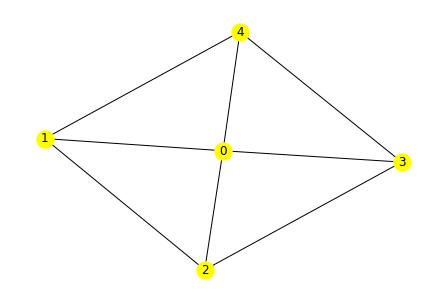

In [2]:
G = nx.wheel_graph(5)
nx.draw(G,node_size=300,with_labels=True,node_color="yellow")

We start at node 4. This corresponds to the probability vector

$$
\bfp = [0,0,0,0,1].
$$

On the first hop, we are equally likely to visit each of the nodes 0, 1, or 3. This implies the probability distribution

$$
\mathbf{q} = \left[\tfrac{1}{3},\tfrac{1}{3},0,\tfrac{1}{3},0\right].
$$

Let's now find the probability of standing on node 0 after the next hop. The two possible histories are 4-1-0 and 4-3-0, with total probability

$$
\underbrace{\frac{1}{3}}_{\text{to 1}} \cdot \underbrace{\frac{1}{3}}_{\text{to 0}} + \underbrace{\frac{1}{3}}_{\text{to 3}} \cdot \underbrace{\frac{1}{3}}_{\text{to 0}} = \frac{2}{9}.
$$

What about node 2 after two hops? The viable paths are 4-0-2, 4-1-2, and 4-3-2. Keeping in mind that node 0 has 4 neighbors, we get

$$
\underbrace{\frac{1}{3}}_{\text{to 0}} \cdot \underbrace{\frac{1}{4}}_{\text{to 2}} + \underbrace{\frac{1}{3}}_{\text{to 1}} \cdot \underbrace{\frac{1}{3}}_{\text{to 2}} + \underbrace{\frac{1}{3}}_{\text{to 3}} \cdot \underbrace{\frac{1}{3}}_{\text{to 2}}= \frac{11}{36}.
$$

This quantity is actually an inner product between the vector $\mathbf{q}$ (probabilities of the prior location) and 

$$
\bfw_2 = \left[ \tfrac{1}{4},\, \tfrac{1}{3},\, 0,\, \tfrac{1}{3},\, 0 \right],
$$

which encodes the chance of hopping directly to node 2 from anywhere. In fact, the entire next vector of probabilities is just

$$
\bigl[ \bfw_1^T \mathbf{q},\, \bfw_2^T \mathbf{q},\, \bfw_3^T \mathbf{q},\, \bfw_4^T \mathbf{q},\, \bfw_5^T \mathbf{q} \bigr] = \bfW \mathbf{q},
$$

where $\bfW$ is the $n\times n$ matrix whose rows are $\bfw_1,\bfw_2,\ldots.$ In terms of matrix-vector multiplications, we have the easy statement that the probability vectors after each hop are

$$
\bfp, \bfW\bfp, \bfW(\bfW\bfp), \ldots.
$$

Explicitly, the matrix $\bfW$ is 

$$
\bfW = \begin{bmatrix} 
0 & \tfrac{1}{3}  & \tfrac{1}{3}  & \tfrac{1}{3}  & \tfrac{1}{3} \\
\tfrac{1}{4} & 0 & \tfrac{1}{3}  & 0  & \tfrac{1}{3} \\
\tfrac{1}{4} & \tfrac{1}{3} & 0 & \tfrac{1}{3} & 0 \\
\tfrac{1}{4} & 0 & \tfrac{1}{3} & 0 & \tfrac{1}{3} \\
\tfrac{1}{4} & \tfrac{1}{3} & 0 & \tfrac{1}{3} & 0
\end{bmatrix}.
$$

This has a lot of resemblance to the adjacency matrix

$$
\bfA = \begin{bmatrix} 
0 & 1  & 1  & 1  & 1 \\
1 & 0 & 1 & 0  & 1 \\
1 & 1 & 0 & 1 & 0 \\
1 & 0 & 1 & 0 & 1 \\
1 & 1 & 0 & 1 & 0
\end{bmatrix}.
$$

The only difference is that each column has to be normalized by the number of options outgoing at that node, i.e., the degree of the node. Thus,

$$
W_{ij} = \frac{1}{\operatorname{deg}(j)}\,A_{ij}.
$$


## Simulating the random walk

Let's do a simulation for a more interesting graph:

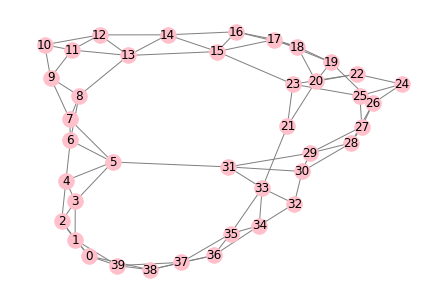

In [3]:
WS = nx.watts_strogatz_graph(40,4,0.04,seed=11)
pos = nx.spring_layout(WS,k=0.25,seed=1,iterations=200)
style = dict(pos=pos,with_labels=True,node_color="pink",edge_color="gray")

nx.draw(WS,node_size=240,**style)

First, we construct the random-walk matrix $\bfW$.

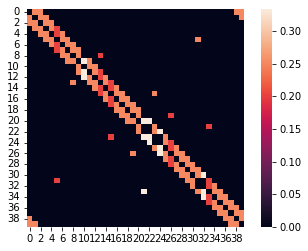

In [4]:
n = WS.number_of_nodes()
A = nx.adjacency_matrix(WS).astype(float)
degree = [WS.degree[i] for i in WS.nodes()]

W = A.copy()
for j in range(n):
    W[:,j] /= degree[j]

sns.heatmap(W.toarray()).set_aspect(1);

We set up a probability vector to start at node 0, and then use `W.dot` to compute the first hop. The result is to end up at 5 other nodes with equal probability:

Total probability after 1 hop: 1.0


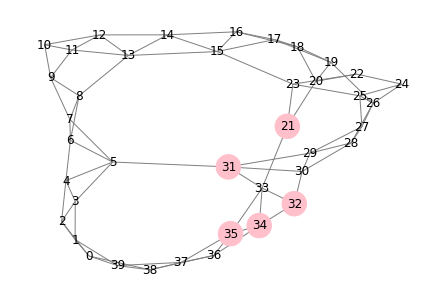

In [5]:
init = 33
p = np.zeros(n)
p[init] = 1
p = W.dot(p)
sz = 3000*p
print("Total probability after 1 hop:",p.sum())
nx.draw(WS,node_size=sz,**style)

After the next hop, there will again be a substantial probability of being at node 33. But we could also be at some second-generation nodes as well.

Total probability after 2 hops: 1.0


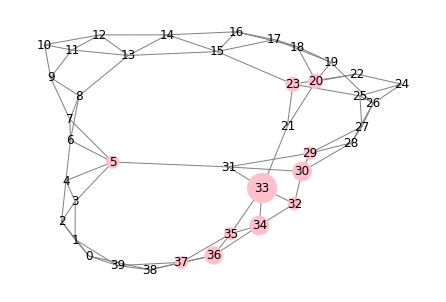

In [6]:
p = W.dot(p)
print("Total probability after 2 hops:",p.sum())
nx.draw(WS,node_size=3000*p,**style)

We'll take 3 more hops. That lets us penetrate a little into the distant nodes.

Total probability after 5 hops: 1.0


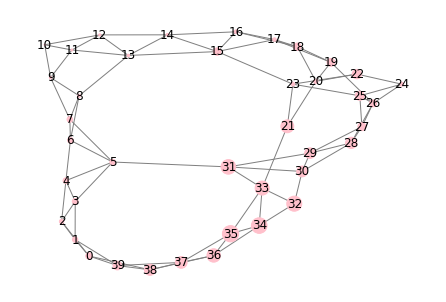

In [7]:
for k in range(3):
    p = W.dot(p)
print("Total probability after 5 hops:",p.sum())
nx.draw(WS,node_size=3000*p,**style)

In the long run, the probabilities even out, as long as the graph is connected.

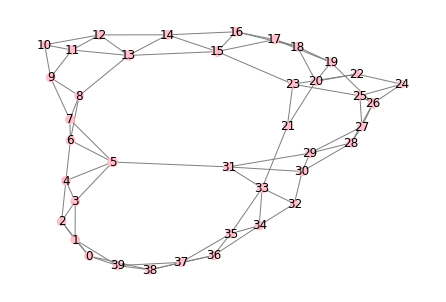

In [8]:
for k in range(200):
    p = W.dot(p)
nx.draw(WS,node_size=3000*p,**style)

## Label propagation

The random walk brings us to a type of algorithm known as **label propagation**. We start off by "labelling" one or several nodes whose community we want to identify. This is equivalent to initializing the probability vector $\bfp$. Then, we take a running total over the entire history of the random walk:

$$
\hat{\bfx} = \lambda \bfp_1  + \lambda^2 \bfp_2 +  \lambda^3 \bfp_3 + \cdots,
$$

where $0 < \lambda < 1$ is a damping parameter, and

$$
\bfp_1 = \bfW \bfp, \, \bfp_2 = \bfW \bfp_1, \, \bfp_3 = \bfW \bfp_2,\, \ldots. 
$$

<!-- 
. It's irresistible (and legit linear algebra) to write $\bfW (\bfW \bfp) = \bfW^2\bfp$ and so on for future iterations. Hence,

$$
\hat{\bfx} = \sum_{k=1}^\infty \lambda^k \bfW^k \bfp.
$$ 
-->

In practice, we terminate the sum once $\lambda^k$ is sufficiently small. The resulting $\hat{\bfx}$ can be normalized to a probability distribution,

$$
\bfx = \frac{\hat{\bfx}}{\norm{\hat{\bfx}}_1}.
$$

The value $x_i$ can be interpreted as the probability of membership in the community.

Let's try looking for a community of node 0 in the WS graph above.

In [9]:
p = np.zeros(n)
p[init] = 1
lam = 0.8

We will compute $\bfx$ by accumulating terms in a loop. Note that there is no need to keep track of the entire history of random-walk probabilities; we just use one generation at a time.

In [10]:
x = np.zeros(n)
mult = 1
for k in range(200):
    p = W.dot(p)
    mult *= lam
    x += mult*p

x /= np.sum(x)  # normalize to probability distribution

The probabilities tend to be distributed logarithmically:

In the following rendering, any node $i$ with a value of $x_i < 10^{-2}$ gets a node size of 0. (You can ignore the warning below. It happens because we have negative node sizes.)

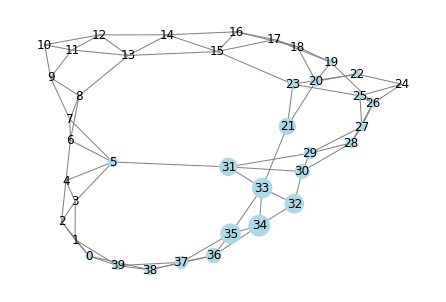

In [11]:
x[x<0.01] = 0
style["node_color"] = "lightblue"
nx.draw(WS,node_size=4000*x,**style)

The parameter $\lambda$ controls how quickly the random-walk process is faded out. A smaller value puts more weight on the early iterations, generally localizing the community more strictly.

In [12]:
p = np.zeros(n)
p[init] = 1
lam = 0.4
x = np.zeros(n)
mult = 1
for k in range(200):
    p = W.dot(p)
    mult *= lam
    x += mult*p

x /= np.sum(x)  

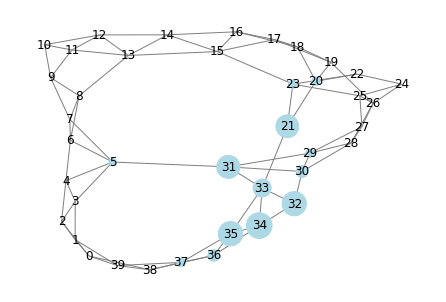

In [13]:
x[x<0.01] = 0
nx.draw(WS,node_size=4000*x,**style)

In practice, we could define a threshold cutoff on the probabilities, or set a community size and take the highest-ranking nodes. Then a new node could be selected and a community identified for it, etc. If communities are not allowed to overlap, then it might make more sense to use a method based on clustering or other criteria.